# Data Openning

In [228]:
!pip install pyspark
! pip install pyspark_dist_explore

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Notebook 1 - Data Wrangling

In [229]:
# Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.types import StructType
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col


# EDA
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

# ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler

In [230]:
spark = SparkSession \
    .builder \
    .appName("Data wrangling with Spark SQL") \
    .getOrCreate()

spark

In [231]:
# local do arquivo
path = "bank-additional-full.csv"

# Lendo o arquivo em um objeto Spark
#df = spark.read.option("delimiter", ";").option("header", "true").option("nullValue", "unknown").option("nullValue", "null").csv(path)
df = spark.read.option("delimiter", ";").option("header", "true").option("inferSchema" , "true").csv(path)


In [232]:
df = df.withColumnRenamed("emp.var.rate","emp_var_rate") \
                        .withColumnRenamed("cons.price.idx","cons_price_idx")\
                        .withColumnRenamed("cons.conf.idx","cons_conf_idx")\
                        .withColumnRenamed("nr.employed","nr_employed")

In [233]:
df.createOrReplaceTempView("df_raw")

**Show dataframe**

In [234]:
df.show(5,truncate=5)

+---+-----+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|  job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
| 56|ho...|  ma...|    ba...|     no|     no|  no|  te...|  may|        mon|     261|       1|  999|       0|   no...|         1.1|         93...|        -36.4|    4.857|      51...| no|
| 57|se...|  ma...|    hi...|  un...|     no|  no|  te...|  may|        mon|     149|       1|  999|       0|   no...|         1.1|         93...|        -36.4|    4.857|      51...| no|
| 37|se...|  ma...|    hi...|     no|    yes|  no|  te...|  may| 

**Print the dataframe Schema**

In [235]:
# Plotando o Schema da tabela spark
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [236]:
print("There is " + str(df.count()) +" samples in this DataFrame")

There is 41188 samples in this DataFrame


**Describe statistics into "pdays" column.**

In [237]:
df.describe("pdays").show()

+-------+-----------------+
|summary|            pdays|
+-------+-----------------+
|  count|            41188|
|   mean|962.4754540157328|
| stddev|186.9109073447411|
|    min|                0|
|    max|              999|
+-------+-----------------+



In [238]:
df.describe("y").show()

+-------+-----+
|summary|    y|
+-------+-----+
|  count|41188|
|   mean| null|
| stddev| null|
|    min|   no|
|    max|  yes|
+-------+-----+



### Cleanning Raw Data



In [239]:
# Task 1 - Replace statements by Null Values

df_1 = df.replace('null', None, subset=['job', 'marital', 'education', 'default', 'housing', 'loan'])\
         .replace('unknown', None, subset=['job', 'marital', 'education', 'default', 'housing', 'loan'])\


# Task 2 -> Replace target values to Boolean variable
df_2 = df_1.withColumn('y', when(df_1['y'] == 'no', 0).otherwise(1))

# Task 3 -> Drop column "duration"
columns_to_drop = ['duration']
df_transient = df_2.drop(*columns_to_drop)

df_transient.show(5,truncate=5)

+---+-----+-------+---------+-------+-------+----+-------+-----+-----------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|  job|marital|education|default|housing|loan|contact|month|day_of_week|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----+-------+---------+-------+-------+----+-------+-----+-----------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
| 56|ho...|  ma...|    ba...|     no|     no|  no|  te...|  may|        mon|       1|  999|       0|   no...|         1.1|         93...|        -36.4|    4.857|      51...|  0|
| 57|se...|  ma...|    hi...|   null|     no|  no|  te...|  may|        mon|       1|  999|       0|   no...|         1.1|         93...|        -36.4|    4.857|      51...|  0|
| 37|se...|  ma...|    hi...|     no|    yes|  no|  te...|  may|        mon|       1|  999|       0|   no...| 

In [240]:
# Final Schema
df_transient.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = false)



In [241]:
df_transient.write.option("header",True).mode("overwrite").option("delimiter",";").csv('data_transient.csv')

## Notebook 2 - Data Engineering

In [242]:
# Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.types import StructType
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col


# EDA
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

# ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler

In [243]:
spark_new = SparkSession \
    .builder \
    .appName("Data Pre Processing with Spark") \
    .getOrCreate()
spark_new

In [244]:
# local do arquivo
path = 'data_transient.csv'

# Lendo o arquivo em um objeto Spark
#df = spark.read.option("delimiter", ";").option("header", "true").option("nullValue", "unknown").option("nullValue", "null").csv(path)

# Define csv input schema
schema = StructType([
    StructField("age", IntegerType()),
    StructField("job", StringType()),
    StructField("marital", StringType()),
    StructField("education", StringType()),
    StructField("default", StringType()),
    StructField("housing", StringType()),
    StructField("loan", StringType()),
    StructField("contact", StringType()),
    StructField("month", StringType()),
    StructField("day_of_week", StringType()),
    StructField("campaign", IntegerType()),
    StructField("pdays", IntegerType()),
    StructField("previous", IntegerType()),
    StructField("poutcome", StringType()),
    StructField("emp_var_rate", DoubleType()),
    StructField("cons_price_idx", DoubleType()),
    StructField("cons_conf_idx", DoubleType()),
    StructField("euribor3m", DoubleType()),
    StructField("nr_employed", DoubleType()),
    StructField("y", IntegerType()),
       
])


df = spark_new.read.option("delimiter", ";").option("header", "true").csv(path, schema=schema)
df.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|  0|
| 57| services|married|high.school|   null|     no|  no|telephone|  may|        mon|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|  0|
| 37| services|married|high.school|     no|    yes|  no

In [245]:
df.createOrReplaceTempView("df_transient")

In [246]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = true)



In [247]:
spark_new.sql('''Select * FROM df_transient''').show(5,truncate=True)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|  0|
| 57| services|married|high.school|   null|     no|  no|telephone|  may|        mon|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|  0|
| 37| services|married|high.school|     no|    yes|  no

**Some Exploratory Analisys - Numerical Data**

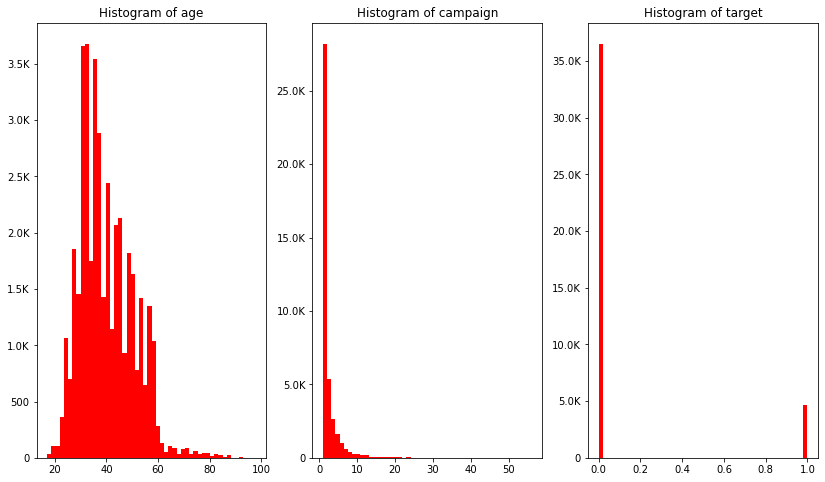

In [248]:
# Plotting histogram
df_eda = df

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(14, 8)

# age histogram
hist(axes[0], df_eda.select('age'), bins = 50, color=['red']);
axes[0].set_title('Histogram of age');

# nr_employed histogram
hist(axes[1], df_eda.select('campaign'), bins = 50, color=['red']);
axes[1].set_title('Histogram of campaign');

# euribor3m histogram
hist(axes[2], df_eda.select('y'), bins = 50, color=['red']);
axes[2].set_title('Histogram of target');


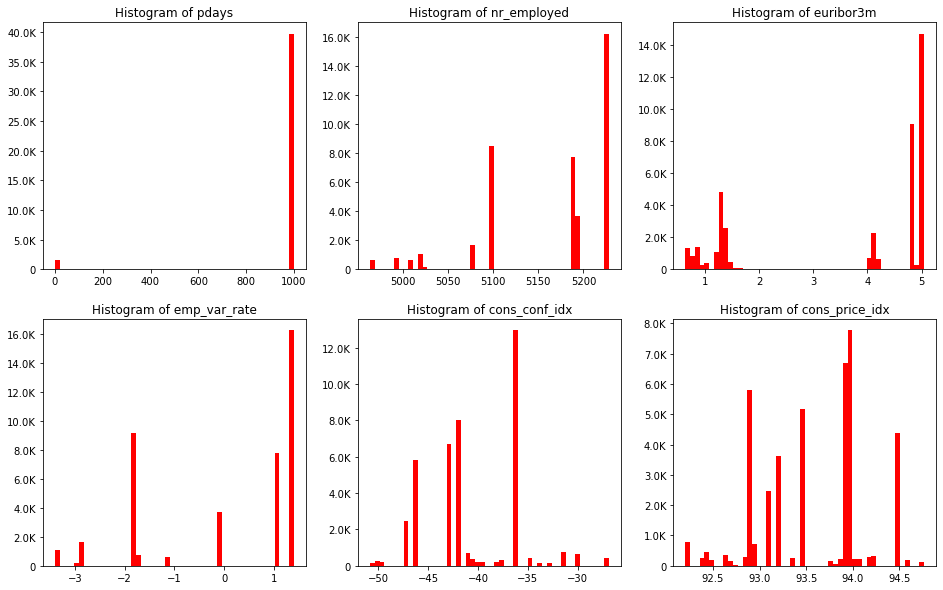

In [249]:
# Plotting histogram - Economic data

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(16, 10)

# pdays histogram
hist(axes[0,0], df_eda.select('pdays'), bins = 50, color=['red']);
axes[0,0].set_title('Histogram of pdays');

# nr_employed histogram
hist(axes[0,1], df_eda.select('nr_employed'), bins = 50, color=['red']);
axes[0,1].set_title('Histogram of nr_employed');

# euribor3m histogram
hist(axes[0,2], df_eda.select('euribor3m'), bins = 50, color=['red']);
axes[0,2].set_title('Histogram of euribor3m');

# emp_var_rate histogram
hist(axes[1,0], df_eda.select('emp_var_rate'), bins = 50, color=['red']);
axes[1,0].set_title('Histogram of emp_var_rate');

# cons_conf_idx histogram
hist(axes[1,1], df_eda.select('cons_conf_idx'), bins = 50, color=['red']);
axes[1,1].set_title('Histogram of cons_conf_idx');

# cons_price_idx histogram
hist(axes[1,2], df_eda.select('cons_price_idx'), bins = 50, color=['red']);
axes[1,2].set_title('Histogram of cons_price_idx');

**Some Exploratory Analisys - Categorical Data**

In [250]:
# Grouping Campaign sucess

spark_new.sql('''
            SELECT CAMPAIGN,
                SUM(QTD) AS QTD_CLI,
                SUM(QTD*FLAG_CONTRATOU) AS QTD_CONTRATOS,
                (SUM(QTD*FLAG_CONTRATOU)/SUM(QTD))*100 AS PERC_CONVERSAO
            FROM (
                  SELECT DISTINCT 
                      campaign,
                      y as flag_contratou,
                      COUNT(*) as qtd 
                  FROM df_transient 
                  GROUP BY campaign, y
              )
            GROUP BY CAMPAIGN
            ORDER BY PERC_CONVERSAO DESC
              ''').show(100)

+--------+-------+-------------+------------------+
|CAMPAIGN|QTD_CLI|QTD_CONTRATOS|    PERC_CONVERSAO|
+--------+-------+-------------+------------------+
|       1|  17642|         2300|13.037070626913048|
|       2|  10570|         1211|11.456953642384105|
|       3|   5341|          574|10.747051114023591|
|       4|   2651|          249|  9.39268200678989|
|       6|    979|           75|7.6608784473953015|
|       5|   1599|          120|   7.5046904315197|
|      17|     58|            4| 6.896551724137931|
|      11|    177|           12| 6.779661016949152|
|      23|     16|            1|              6.25|
|       7|    629|           38| 6.041335453100159|
|       9|    283|           17| 6.007067137809187|
|      10|    225|           12| 5.333333333333334|
|      13|     92|            4|4.3478260869565215|
|       8|    400|           17|              4.25|
|      15|     51|            2|3.9215686274509802|
|      12|    125|            3|               2.4|
|      14|  

In [251]:
# Grouping by job the campaign conversion

spark_new.sql('''
            SELECT job,
                SUM(QTD) AS QTD_CLI,
                SUM(QTD*FLAG_CONTRATOU) AS QTD_CONTRATOS,
                (SUM(QTD*FLAG_CONTRATOU)/SUM(QTD))*100 AS PERC_CONVERSAO
            FROM (
                  SELECT DISTINCT 
                      job,
                      y as flag_contratou,
                      COUNT(*) as qtd 
                  FROM df_transient 
                  GROUP BY job, y
              )
            GROUP BY job
            ORDER BY PERC_CONVERSAO DESC
              ''').show(100)

+-------------+-------+-------------+------------------+
|          job|QTD_CLI|QTD_CONTRATOS|    PERC_CONVERSAO|
+-------------+-------+-------------+------------------+
|      student|    875|          275|31.428571428571427|
|      retired|   1720|          434|25.232558139534884|
|   unemployed|   1014|          144|14.201183431952662|
|       admin.|  10422|         1352|12.972558050278257|
|   management|   2924|          328| 11.21751025991792|
|         null|    330|           37|11.212121212121213|
|   technician|   6743|          730|10.826041821147857|
|self-employed|   1421|          149| 10.48557353976073|
|    housemaid|   1060|          106|              10.0|
| entrepreneur|   1456|          124| 8.516483516483516|
|     services|   3969|          323| 8.138070042831949|
|  blue-collar|   9254|          638| 6.894315971471795|
+-------------+-------+-------------+------------------+



In [252]:
# Grouping by education the campaign conversion

spark_new.sql('''
            SELECT education,
                SUM(QTD) AS QTD_CLI,
                SUM(QTD*FLAG_CONTRATOU) AS QTD_CONTRATOS,
                (SUM(QTD*FLAG_CONTRATOU)/SUM(QTD))*100 AS PERC_CONVERSAO
            FROM (
                  SELECT DISTINCT 
                      education,
                      y as flag_contratou,
                      COUNT(*) as qtd 
                  FROM df_transient 
                  GROUP BY education, y
              )
            GROUP BY education
            ORDER BY PERC_CONVERSAO DESC
              ''').show(100)

+-------------------+-------+-------------+------------------+
|          education|QTD_CLI|QTD_CONTRATOS|    PERC_CONVERSAO|
+-------------------+-------+-------------+------------------+
|         illiterate|     18|            4| 22.22222222222222|
|               null|   1731|          251|14.500288850375506|
|  university.degree|  12168|         1670|13.724523339907954|
|professional.course|   5243|          595|11.348464619492656|
|        high.school|   9515|         1031|10.835522858644246|
|           basic.4y|   4176|          428| 10.24904214559387|
|           basic.6y|   2292|          188| 8.202443280977311|
|           basic.9y|   6045|          473|  7.82464846980976|
+-------------------+-------+-------------+------------------+



In [253]:
# Grouping by marital status the campaign conversion

spark_new.sql('''
            SELECT marital,
                SUM(QTD) AS QTD_CLI,
                SUM(QTD*FLAG_CONTRATOU) AS QTD_CONTRATOS,
                (SUM(QTD*FLAG_CONTRATOU)/SUM(QTD))*100 AS PERC_CONVERSAO
            FROM (
                  SELECT DISTINCT 
                      marital,
                      y as flag_contratou,
                      COUNT(*) as qtd 
                  FROM df_transient 
                  GROUP BY marital, y
              )
            GROUP BY marital
            ORDER BY PERC_CONVERSAO DESC
              ''').show(100)

+--------+-------+-------------+------------------+
| marital|QTD_CLI|QTD_CONTRATOS|    PERC_CONVERSAO|
+--------+-------+-------------+------------------+
|    null|     80|           12|              15.0|
|  single|  11568|         1620|14.004149377593361|
|divorced|   4612|          476|10.320901994796184|
| married|  24928|         2532|10.157252888318355|
+--------+-------+-------------+------------------+



In [254]:
# Grouping by contact status the campaign conversion

spark_new.sql('''
            SELECT contact,
                SUM(QTD) AS QTD_CLI,
                SUM(QTD*FLAG_CONTRATOU) AS QTD_CONTRATOS,
                (SUM(QTD*FLAG_CONTRATOU)/SUM(QTD))*100 AS PERC_CONVERSAO
            FROM (
                  SELECT DISTINCT 
                      contact,
                      y as flag_contratou,
                      COUNT(*) as qtd 
                  FROM df_transient 
                  GROUP BY contact, y
              )
            GROUP BY contact
            ORDER BY PERC_CONVERSAO DESC
              ''').show(100)

+---------+-------+-------------+------------------+
|  contact|QTD_CLI|QTD_CONTRATOS|    PERC_CONVERSAO|
+---------+-------+-------------+------------------+
| cellular|  26144|         3853|14.737607099143208|
|telephone|  15044|          787| 5.231321457059293|
+---------+-------+-------------+------------------+



In [255]:
# Grouping by default status the campaign conversion

spark_new.sql('''
            SELECT default,
                SUM(QTD) AS QTD_CLI,
                SUM(QTD*FLAG_CONTRATOU) AS QTD_CONTRATOS,
                (SUM(QTD*FLAG_CONTRATOU)/SUM(QTD))*100 AS PERC_CONVERSAO
            FROM (
                  SELECT DISTINCT 
                      default,
                      y as flag_contratou,
                      COUNT(*) as qtd 
                  FROM df_transient 
                  GROUP BY default, y
              )
            GROUP BY default
            ORDER BY PERC_CONVERSAO DESC
              ''').show(100)

+-------+-------+-------------+------------------+
|default|QTD_CLI|QTD_CONTRATOS|    PERC_CONVERSAO|
+-------+-------+-------------+------------------+
|     no|  32588|         4197|12.878973855406898|
|   null|   8597|          443| 5.152960335000581|
|    yes|      3|            0|               0.0|
+-------+-------+-------------+------------------+



In [256]:
# Grouping by housing status the campaign conversion

spark_new.sql('''
            SELECT housing,
                SUM(QTD) AS QTD_CLI,
                SUM(QTD*FLAG_CONTRATOU) AS QTD_CONTRATOS,
                (SUM(QTD*FLAG_CONTRATOU)/SUM(QTD))*100 AS PERC_CONVERSAO
            FROM (
                  SELECT DISTINCT 
                      housing,
                      y as flag_contratou,
                      COUNT(*) as qtd 
                  FROM df_transient 
                  GROUP BY housing, y
              )
            GROUP BY housing
            ORDER BY PERC_CONVERSAO DESC
              ''').show(100)

+-------+-------+-------------+------------------+
|housing|QTD_CLI|QTD_CONTRATOS|    PERC_CONVERSAO|
+-------+-------+-------------+------------------+
|    yes|  21576|         2507|11.619391916944753|
|     no|  18622|         2026|10.879604768553323|
|   null|    990|          107|10.808080808080808|
+-------+-------+-------------+------------------+



In [257]:
# Grouping by loan status the campaign conversion

spark_new.sql('''
            SELECT loan,
                SUM(QTD) AS QTD_CLI,
                SUM(QTD*FLAG_CONTRATOU) AS QTD_CONTRATOS,
                (SUM(QTD*FLAG_CONTRATOU)/SUM(QTD))*100 AS PERC_CONVERSAO
            FROM (
                  SELECT DISTINCT 
                      loan,
                      y as flag_contratou,
                      COUNT(*) as qtd 
                  FROM df_transient 
                  GROUP BY loan, y
              )
            GROUP BY loan
            ORDER BY PERC_CONVERSAO DESC
              ''').show(100)

+----+-------+-------------+------------------+
|loan|QTD_CLI|QTD_CONTRATOS|    PERC_CONVERSAO|
+----+-------+-------------+------------------+
|  no|  33950|         3850| 11.34020618556701|
| yes|   6248|          683|10.931498079385403|
|null|    990|          107|10.808080808080808|
+----+-------+-------------+------------------+



In [258]:
# Grouping by day_of_week status the campaign conversion

spark_new.sql('''
            SELECT day_of_week,
                SUM(QTD) AS QTD_CLI,
                SUM(QTD*FLAG_CONTRATOU) AS QTD_CONTRATOS,
                (SUM(QTD*FLAG_CONTRATOU)/SUM(QTD))*100 AS PERC_CONVERSAO
            FROM (
                  SELECT DISTINCT 
                      day_of_week,
                      y as flag_contratou,
                      COUNT(*) as qtd 
                  FROM df_transient 
                  GROUP BY day_of_week, y
              )
            GROUP BY day_of_week
            ORDER BY PERC_CONVERSAO DESC
              ''').show(100)

+-----------+-------+-------------+------------------+
|day_of_week|QTD_CLI|QTD_CONTRATOS|    PERC_CONVERSAO|
+-----------+-------+-------------+------------------+
|        thu|   8623|         1045|12.118752174417256|
|        tue|   8090|          953|11.779975278121137|
|        wed|   8134|          949|11.667076469141874|
|        fri|   7827|          846| 10.80873898045228|
|        mon|   8514|          847| 9.948320413436692|
+-----------+-------+-------------+------------------+



### Data Engeneering

In [259]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = true)



In [260]:
# Task 1 - Replace statements  in education and job columns

# Rules (education):
# 'Basic incomplete' : 'illiterate' 'basic.4y', 'basic.6y'
# 'Basic Degree': 'basic.9y'
# 'High School ': 'high.school'
# 'Higher Education Degree': 'university.degree', 'professional.course'

# Rules (job):
# 'retired' : 'retired' 
# 'student': 'student'
# 'unemployed' : 'unemployed'
# 'housemaid' : housemaid'
# 'employed': 'admin.' , 'technician', 'services', 'management'
# 'enterpreneur': 'self-employed', 'blue-collar' , 'entrepreneur'
df_1_new = df.withColumn('education',when(df.education == 'illiterate','Basic incomplete')  \
           .when(df.education == 'basic.4y','Basic incomplete')\
           .when(df.education == 'basic.6y','Basic incomplete') \
           .when(df.education == 'basic.9y','Basic Degree') \
           .when(df.education == 'high.school', 'High School') \
           .when(df.education == 'university.degree', 'Higher Education Degree') \
           .when(df.education == 'professional.course','Higher Education Degree') \
           .otherwise(df.education))\
            .withColumn('job', when(df.job == 'blue-collar','enterpreneur')\
                        .when(df.job == 'self-employed', 'enterpreneur') \
                        .when(df.job == 'management','employed') \
                        .when(df.job == 'admin.','employed') \
                        .when(df.job == 'technician','employed')\
                        .when(df.job == 'services','employed').otherwise(df.job))


# Task 2 - Replace statements by Boolean type
# contact,  housing, loan, contact, marital
df_2_new = df_1_new.withColumn('contact', when(df_1_new.contact == 'telephone', 0).otherwise(1))\
    .withColumn('marital', when(df_1_new.marital == 'single', 1).otherwise(0))\
    .withColumn('loan', when(df_1_new.loan == 'yes', 1).otherwise(0))\
    .withColumn('housing', when(df_1_new.housing == 'no', 0).otherwise(1))


# Task 3 - Drop default, month and campaign
# contact,  housing, loan, contact, marital
columns_to_drop = ['default', 'month', 'campaign', 'poutcome', 'nr_employed']
df_trusted = df_2_new.drop(*columns_to_drop)


# Task 4 -> Fill na
# columns-> all columns
df_trusted = df_trusted.fillna( { 'job':'employed',
                              'education':'Higher Education Degree',
                              'pdays':0} )
df_trusted.show(5)

+---+---------+-------+----------------+-------+----+-------+-----------+-----+--------+------------+--------------+-------------+---------+---+
|age|      job|marital|       education|housing|loan|contact|day_of_week|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|  y|
+---+---------+-------+----------------+-------+----+-------+-----------+-----+--------+------------+--------------+-------------+---------+---+
| 56|housemaid|      0|Basic incomplete|      0|   0|      0|        mon|  999|       0|         1.1|        93.994|        -36.4|    4.857|  0|
| 57| employed|      0|     High School|      0|   0|      0|        mon|  999|       0|         1.1|        93.994|        -36.4|    4.857|  0|
| 37| employed|      0|     High School|      1|   0|      0|        mon|  999|       0|         1.1|        93.994|        -36.4|    4.857|  0|
| 40| employed|      0|Basic incomplete|      0|   0|      0|        mon|  999|       0|         1.1|        93.994|        -36.4|

**Counting null values**

In [261]:
df_trusted.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_trusted.columns]).show()

+---+---+-------+---------+-------+----+-------+-----------+-----+--------+------------+--------------+-------------+---------+---+
|age|job|marital|education|housing|loan|contact|day_of_week|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|  y|
+---+---+-------+---------+-------+----+-------+-----------+-----+--------+------------+--------------+-------------+---------+---+
|  0|  0|      0|        0|      0|   0|      0|          0|    0|       0|           0|             0|            0|        0|  0|
+---+---+-------+---------+-------+----+-------+-----------+-----+--------+------------+--------------+-------------+---------+---+



**Saving Data**

In [262]:
df_trusted.write.option("header",True).mode("overwrite").option("delimiter",";").csv('data_trusted.csv')

## Data Modeling

In [263]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType

# Pre Processing
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler

# Machine Learning
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier, MultilayerPerceptronClassifier, LinearSVC, NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

In [264]:
spark_model = SparkSession \
    .builder \
    .appName("Data Modeling with Spark") \
    .getOrCreate()

In [265]:
spark_model

In [266]:
# local do arquivo
path = 'data_trusted.csv'

# Lendo o arquivo em um objeto Spark
#df = spark.read.option("delimiter", ";").option("header", "true").option("nullValue", "unknown").option("nullValue", "null").csv(path)

# Define csv input schema
schema = StructType([
    StructField("age", IntegerType()),
    StructField("job", StringType()),
    StructField("marital", IntegerType()),
    StructField("education", StringType()),
    StructField("housing", IntegerType()),
    StructField("loan", IntegerType()),
    StructField("contact", IntegerType()),
    StructField("day_of_week", StringType()),
    StructField("pdays", IntegerType()),
    StructField("previous", IntegerType()),
    StructField("emp_var_rate", FloatType()),
    StructField("cons_price_idx", FloatType()),
    StructField("cons_conf_idx", FloatType()),
    StructField("euribor3m", FloatType()),
    StructField("y", IntegerType()),
])

df_model = spark_model.read.option("delimiter", ";").option("header", "true").csv(path, schema=schema)

df_model.show(5)
#df_model.printSchema()

+---+---------+-------+----------------+-------+----+-------+-----------+-----+--------+------------+--------------+-------------+---------+---+
|age|      job|marital|       education|housing|loan|contact|day_of_week|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|  y|
+---+---------+-------+----------------+-------+----+-------+-----------+-----+--------+------------+--------------+-------------+---------+---+
| 56|housemaid|      0|Basic incomplete|      0|   0|      0|        mon|  999|       0|         1.1|        93.994|        -36.4|    4.857|  0|
| 57| employed|      0|     High School|      0|   0|      0|        mon|  999|       0|         1.1|        93.994|        -36.4|    4.857|  0|
| 37| employed|      0|     High School|      1|   0|      0|        mon|  999|       0|         1.1|        93.994|        -36.4|    4.857|  0|
| 40| employed|      0|Basic incomplete|      0|   0|      0|        mon|  999|       0|         1.1|        93.994|        -36.4|

In [267]:
############################################ Split data
df_train, df_test = df_model.randomSplit(weights = [0.80, 0.20], seed = 42)

print("Training Dataset Count: " + str(df_train.count()))
print("Test Dataset Count: " + str(df_test.count()))

Training Dataset Count: 33015
Test Dataset Count: 8173


In [268]:
############################################ Prepara data -> get dtypes
dt = df_train.dtypes
  
# get columns by type
categoricalList = [item[0] for item in dt if item[1].startswith('string') or item[1].startswith('bigint')]
numList = [item[0] for item in dt if item[1].startswith('int') or item[1].startswith('float')]

print("Result Categorical: ", categoricalList)
print("Result Numerical: ", numList)

Result Categorical:  ['job', 'education', 'day_of_week']
Result Numerical:  ['age', 'marital', 'housing', 'loan', 'contact', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'y']


**Pré Processing Pipeline**



In [269]:
###############################################################################
# Task 1 -> String Indexer
# columns-> ['job', 'education','day_of_week']
# output columns-> ['job_StringIndexer', 'education_StringIndexer','day_of_week_StringIndexer']
stage_string = [StringIndexer(inputCol= c, outputCol= c+"_StringIndexer", handleInvalid="keep") for c in categoricalList]


###############################################################################
# Task 2 -> One Hot Encoder
# columns-> ['job_new', 'education','day_of_week']
# output columns-> ['job_OneHotEncoder', 'education_OneHotEncoder','day_of_week_OneHotEncoder']
stage_one_hot = [OneHotEncoder(inputCol= f"{c}_StringIndexer", outputCol= f"{c}_OneHotEncoder") for c in categoricalList]


###############################################################################
# Task 3 -> Vector Assembler
# allow us to use ML methods and standard scaler
# columns-> all columns
colunas = numList + ['job_OneHotEncoder', 'education_OneHotEncoder','day_of_week_OneHotEncoder']
stage_vector_assembler = [VectorAssembler(inputCols=colunas,   outputCol='features') ]


###############################################################################
# Task 4 -> Standard Scaler
# columns-> all columns
stage_standard_scaler = StandardScaler().setInputCol("features")

###############################################################################
# Creta an list os sequential steps of your pipeline
stages_pre_processing = stage_string+ stage_one_hot+ stage_vector_assembler+ [stage_standard_scaler]
stages_pre_processing

[StringIndexer_d5fb125dcf84,
 StringIndexer_72c1ee7d82ed,
 StringIndexer_982b81c40676,
 OneHotEncoder_b322ded1d0b1,
 OneHotEncoder_622c3ae90b34,
 OneHotEncoder_ec87ce279f95,
 VectorAssembler_a1deea27eb21,
 StandardScaler_6649839feb88]

In [270]:
%%time
# Make Pipeline 

# create object
ppl = Pipeline().setStages(stages_pre_processing)

# Trainning pipeline
# allow us save pipeline
pipelineModel = ppl.fit(df_train)

# Applying changes
df_train_clean  = pipelineModel.transform(df_train)
df_test_clean  = pipelineModel.transform(df_test)

df_train_clean.show(2,truncate=True)

+---+-------+-------+----------------+-------+----+-------+-----------+-----+--------+------------+--------------+-------------+---------+---+-----------------+-----------------------+-------------------------+-----------------+-----------------------+-------------------------+--------------------+-----------------------------------+
|age|    job|marital|       education|housing|loan|contact|day_of_week|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|  y|job_StringIndexer|education_StringIndexer|day_of_week_StringIndexer|job_OneHotEncoder|education_OneHotEncoder|day_of_week_OneHotEncoder|            features|StandardScaler_6649839feb88__output|
+---+-------+-------+----------------+-------+----+-------+-----------+-----+--------+------------+--------------+-------------+---------+---+-----------------+-----------------------+-------------------------+-----------------+-----------------------+-------------------------+--------------------+-----------------------------

**Saving Pipeline**

In [272]:
# Save pipeline

pipelineModel.save("pipeline_pre_processing_1")

**Checking final dataframe**

In [273]:
# Up the data to cache to models learn faster
df_train_clean.cache()
df_test_clean.cache()

df_train_clean.select(['features']).show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                        |
+------------------------------------------------------------------------------------------------------------------------------------------------+
|(28,[0,1,4,5,7,8,9,10,18,21,23],[18.0,1.0,1.0,999.0,-1.7999999523162842,93.07499694824219,-47.099998474121094,1.3650000095367432,1.0,1.0,1.0])  |
|(28,[0,1,4,5,7,8,9,10,18,22,23],[19.0,1.0,1.0,999.0,-1.7999999523162842,93.07499694824219,-47.099998474121094,1.409999966621399,1.0,1.0,1.0])   |
|(28,[0,1,4,5,7,8,9,10,18,22,26],[19.0,1.0,1.0,999.0,-1.7999999523162842,93.07499694824219,-47.099998474121094,1.4529999494552612,1.0,1.0,1.0])  |
|(28,[0,1,2,4,5,7,8,9,10,11,18,22,27],[19.0,1.0,1.0,1.0,999.0,-1.7999999523162842,92.84300231933594,-50.0,1.6399999856

## Models

* Logistic Regression
* Decision Tree
* Random Forest
* Gradient-boosted tree
* Linear Support Vector Machine
* Naive Bayes

#### **Metrics**

In [274]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np

main_metric = BCE(labelCol = "y",\
                    rawPredictionCol = "prediction",\
                    metricName = "areaUnderROC")

def valuation_metrics(df, model):
    
    # Create both evaluators
    evaluatorMulti = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction")

    # Make predicitons
    predictionAndTarget = model.transform(df).select("y", "prediction")
    
    data_y =  np.array(predictionAndTarget.select("y").collect())
    data_pred =  np.array(predictionAndTarget.select("prediction").collect())


    # Get metrics
    acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
    f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
    weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
    weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
    auc = main_metric.evaluate(predictionAndTarget)

    
    print("Summary Stats")
    print('Accuracy:', acc)
    print('F1-Score:', f1)
    print('weightedPrecision:', weightedPrecision)
    print('AUC:', auc)
    
    logreg_matrix = confusion_matrix(data_y, data_pred)

    print("Confusion Matrix", logreg_matrix)
    print('acuracy', accuracy_score(data_y,data_pred))
    print('f1_score',f1_score(data_y,data_pred) )
    print('End Metrics \n')

**Logistic Regression**

In [275]:
%%time

# Create model object
lr = LogisticRegression(labelCol ='y',featuresCol="features")

# fit parameters grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [ 0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [5, 10, 20]) \
    .build()


# cross validation
crossval = CrossValidator(estimator = lr,
                            estimatorParamMaps=paramGrid,
                            evaluator = main_metric,
                            numFolds= 5)

cv_model_lr = crossval.fit(df_train_clean)

CPU times: user 5.69 s, sys: 1.84 s, total: 7.52 s
Wall time: 1min 48s


In [276]:
print("Train Metrics:")
valuation_metrics(df_train_clean,cv_model_lr)

print("Test Metrics:")
valuation_metrics(df_test_clean,cv_model_lr)

Train Metrics:
Summary Stats
Accuracy: 1.0
F1-Score: 1.0
weightedPrecision: 1.0
AUC: 1.0
Confusion Matrix [[29288     0]
 [    0  3727]]
acuracy 1.0
f1_score 1.0
End Metrics 

Test Metrics:
Summary Stats
Accuracy: 1.0
F1-Score: 1.0
weightedPrecision: 1.0
AUC: 1.0
Confusion Matrix [[7260    0]
 [   0  913]]
acuracy 1.0
f1_score 1.0
End Metrics 



**Decision Tree**

In [277]:
%%time

# Create model object
dt = DecisionTreeClassifier(labelCol ='y',featuresCol="features")

# fit parameters grid

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10, 20, 30]) \
    .addGrid(dt.maxBins, [10, 20, 40, 80, 100]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()


# cross validation
crossval_dt = CrossValidator(estimator = dt,
                            estimatorParamMaps=paramGrid,
                            evaluator = main_metric,
                            numFolds= 5)

cv_model_dt = crossval_dt.fit(df_train_clean)

CPU times: user 9.93 s, sys: 3.42 s, total: 13.4 s
Wall time: 2min 21s


In [278]:
%%time

print("Train Metrics:\n")
valuation_metrics(df_train_clean,cv_model_dt)

print("Test Metrics:\n")
valuation_metrics(df_test_clean,cv_model_dt)

Train Metrics:

Summary Stats
Accuracy: 1.0
F1-Score: 1.0
weightedPrecision: 1.0
AUC: 1.0
Confusion Matrix [[29288     0]
 [    0  3727]]
acuracy 1.0
f1_score 1.0
End Metrics 

Test Metrics:

Summary Stats
Accuracy: 1.0
F1-Score: 1.0
weightedPrecision: 1.0
AUC: 1.0
Confusion Matrix [[7260    0]
 [   0  913]]
acuracy 1.0
f1_score 1.0
End Metrics 

CPU times: user 1.42 s, sys: 0 ns, total: 1.42 s
Wall time: 2.93 s


**Random Forest**

In [279]:
%%time
# Create model object
random_forest = RandomForestClassifier(labelCol = "y", featuresCol = "features")

# fit parameters grid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 10, 30]) \
    .addGrid(dt.maxBins, [10, 40, 100]) \
    .addGrid(random_forest.numTrees, [20, 30, 50, 100]) \
    .build()


# cross validation
crossval = CrossValidator(estimator = random_forest,
                            estimatorParamMaps=paramGrid,
                            evaluator = main_metric,
                            numFolds= 5)

cv_model_rf = crossval.fit(df_train_clean)

CPU times: user 8.86 s, sys: 2.37 s, total: 11.2 s
Wall time: 6min 18s


In [280]:
%%time

print("Train Metrics:\n")
valuation_metrics(df_train_clean,cv_model_rf)

print("Test Metrics:\n")
valuation_metrics(df_test_clean,cv_model_rf)

Train Metrics:

Summary Stats
Accuracy: 1.0
F1-Score: 1.0
weightedPrecision: 1.0
AUC: 1.0
Confusion Matrix [[29288     0]
 [    0  3727]]
acuracy 1.0
f1_score 1.0
End Metrics 

Test Metrics:

Summary Stats
Accuracy: 1.0
F1-Score: 1.0
weightedPrecision: 1.0
AUC: 1.0
Confusion Matrix [[7260    0]
 [   0  913]]
acuracy 1.0
f1_score 1.0
End Metrics 

CPU times: user 1.37 s, sys: 0 ns, total: 1.37 s
Wall time: 4.85 s


**Gradient-boosted tree**

In [281]:
%%time

# Create model object
gbt = GBTClassifier(labelCol ='y', featuresCol = "features")

# fit parameters grid

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 5, 10])\
    .addGrid(gbt.maxBins, [10, 20, 40])\
    .addGrid(gbt.maxIter, [5, 10, 20])\
    .build()


# cross validation
crossval = CrossValidator(estimator = gbt,
                            estimatorParamMaps=paramGrid,
                            evaluator = main_metric,
                            numFolds= 5)

cv_model_gbt = crossval.fit(df_train_clean)

CPU times: user 20.3 s, sys: 4.88 s, total: 25.2 s
Wall time: 30min 4s


In [282]:
%%time
print("Train Metrics:\n")
valuation_metrics(df_train_clean,cv_model_gbt)

print("Test Metrics:\n")
valuation_metrics(df_test_clean,cv_model_gbt)

Train Metrics:

Summary Stats
Accuracy: 1.0
F1-Score: 1.0
weightedPrecision: 1.0
AUC: 1.0
Confusion Matrix [[29288     0]
 [    0  3727]]
acuracy 1.0
f1_score 1.0
End Metrics 

Test Metrics:

Summary Stats
Accuracy: 1.0
F1-Score: 1.0
weightedPrecision: 1.0
AUC: 1.0
Confusion Matrix [[7260    0]
 [   0  913]]
acuracy 1.0
f1_score 1.0
End Metrics 

CPU times: user 4.11 s, sys: 0 ns, total: 4.11 s
Wall time: 11.4 s


**Linear Support Vector Machine**

In [283]:
%%time

# Create model object
lsvc = LinearSVC(labelCol ='y')

# fit parameters grid

#### falta configurar aqui

paramGrid = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [5, 10, 50]) \
    .addGrid(lsvc.regParam, [0.001, 0.01, 1.0]) \
    .build()


# cross validation
crossval = CrossValidator(estimator = lsvc,
                            estimatorParamMaps=paramGrid,
                            evaluator = main_metric,
                            numFolds= 5)

cv_model_svm = crossval.fit(df_train_clean)

CPU times: user 5.09 s, sys: 1.19 s, total: 6.28 s
Wall time: 8min 27s


In [284]:
%%time
print("Train Metrics:\n")
valuation_metrics(df_train_clean,cv_model_svm)

print("Test Metrics:\n")
valuation_metrics(df_test_clean,cv_model_svm)

Train Metrics:

Summary Stats
Accuracy: 1.0
F1-Score: 1.0
weightedPrecision: 1.0
AUC: 1.0
Confusion Matrix [[29288     0]
 [    0  3727]]
acuracy 1.0
f1_score 1.0
End Metrics 

Test Metrics:

Summary Stats
Accuracy: 1.0
F1-Score: 1.0
weightedPrecision: 1.0
AUC: 1.0
Confusion Matrix [[7260    0]
 [   0  913]]
acuracy 1.0
f1_score 1.0
End Metrics 

CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 3.61 s


In [285]:
cv_model_lr.avgMetrics
cv_model_dt.avgMetrics
cv_model_rf.avgMetrics
cv_model_gbt.avgMetrics
cv_model_svm.avgMetrics

[0.5, 0.5, 0.5, 0.6, 0.6, 0.5, 1.0, 1.0, 1.0]

### Results


| Models                        | Time     | Accuracy | AUC |
|-------------------------------|----------|----------|-----|
| Logistic Regression           | 1min 54s | 1.0      | 1.0 |
| Decision Tree                 | 2min 32s | 1.0      | 1.0 |
| Random Forest                 | 5min 36s | 1.0      | 1.0 |
| Gradient-boosted tree         | 7min 12s | 1.0      | 1.0 |
| Linear Support Vector Machine | 2min 14s | 1.0      | 1.0 |




In [286]:
# Save best model

cv_model.save("best_model")

NameError: name 'cv_model' is not defined